## Importing Libraries

In [1]:
import json
import time
from collections import defaultdict
from pathlib import Path


import cv2
import numpy as np
import pandas as pd

from ultralytics import YOLO

## Custom Lane Maker

In [10]:

zones = []
current_zone = []
drawing = False

# Resize helper
def resize_frame(frame, max_width=1280, max_height=720):
    h, w = frame.shape[:2]
    scale = min(max_width / w, max_height / h)
    new_w, new_h = int(w * scale), int(h * scale)
    return cv2.resize(frame, (new_w, new_h)), scale

def mouse_callback(event, x, y, flags, param):
    global current_zone, drawing
    if event == cv2.EVENT_LBUTTONDOWN:   # Left click = add point
        current_zone.append((x, y))
        drawing = True
    elif event == cv2.EVENT_RBUTTONDOWN:  # Right click = finish polygon
        if len(current_zone) >= 3:
            zones.append({"points": current_zone.copy()})
            print(f"Zone saved: {current_zone}")
        current_zone = []
        drawing = False

video_path = r"D:\Project\Traffic\Traffic2.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

# Resize frame to fit screen
frame, scale = resize_frame(frame, max_width=1280, max_height=720)

cv2.namedWindow("Draw Zones (Left=Add, Right=Finish, ESC=Exit)")
cv2.setMouseCallback("Draw Zones (Left=Add, Right=Finish, ESC=Exit)", mouse_callback)

while True:
    temp_frame = frame.copy()

    # Draw finished zones
    for z in zones:
        pts = [(int(p[0]), int(p[1])) for p in z["points"]]
        cv2.polylines(temp_frame, [np.array(pts, np.int32)], True, (0,255,0), 2)

    # Draw current in-progress zone
    if current_zone:
        pts = [(int(p[0]), int(p[1])) for p in current_zone]
        cv2.polylines(temp_frame, [np.array(pts, np.int32)], False, (0,0,255), 2)

    cv2.imshow("Draw Zones (Left=Add, Right=Finish, ESC=Exit)", temp_frame)
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC = exit
        break

cv2.destroyAllWindows()

# Save zones to JSON
with open("zones.json", "w") as f:
    json.dump({"zones": zones}, f, indent=2)

print("Zones saved to zones.json ✅")


Zone saved: [(125, 57), (364, 74), (192, 718), (1, 716), (3, 239), (124, 56)]
Zone saved: [(364, 75), (606, 78), (669, 714), (191, 719), (366, 76)]
Zone saved: [(608, 75), (782, 72), (1087, 706), (670, 712), (605, 72)]
Zone saved: [(785, 75), (931, 67), (1279, 511), (1275, 710), (1088, 700), (784, 73)]
Zones saved to zones.json ✅


## Loading zone

In [2]:
def is_point_in_poly(point, poly):
    """Check if a point (x, y) is inside a polygon."""
    return cv2.pointPolygonTest(np.array(poly, dtype=np.int32), point, False) >= 0

def load_zones(zones_file):
    """Load zones from JSON (your format with 'zones' and 'points')"""
    with open(zones_file, 'r') as f:
        data = json.load(f)
    
    zones_int = []
    for zone in data["zones"]:
        points = zone["points"]
        poly_int = [[int(x), int(y)] for x, y in points]
        zones_int.append(poly_int)
    return zones_int


## Processing Video

In [3]:
def resize_frame(frame, max_width=1280):
   
    h, w = frame.shape[:2]
    if w > max_width:
        ratio = max_width / w
        frame = cv2.resize(frame, (int(w * ratio), int(h * ratio)))
    return frame  # <-- return only the NumPy array




CLASS_COLORS = {2: (0,255,0), 5: (255,0,0), 7: (0,0,255)}
CLASS_NAMES = {2: "car", 5: "bus", 7: "truck"}


def process_video(video_path, model_path, output_path, save_csv, zones_file=None, resize_width=1280):
    # Load YOLO model
    model = YOLO(model_path)
    zones = load_zones(zones_file) if zones_file else []

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_path}")

    ret, frame = cap.read()
    if not ret:
        raise IOError("Cannot read first frame")
    frame = resize_frame(frame, resize_width)
    height, width = frame.shape[:2]
    fps = cap.get(cv2.CAP_PROP_FPS) or 30
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Global unique IDs per zone+class
    unique_ids_per_zone = {f"zone_{j}_class_{cls_id}": set() 
                           for j in range(len(zones)) 
                           for cls_id in [2,5,7]}

    # Per-frame new entries
    per_frame_counts = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = resize_frame(frame, resize_width)

        results = model.track(source=frame, persist=True, tracker="bytetrack.yaml")
        res = next(iter(results))

        # Prepare lists for detection info
        boxes, scores, track_ids, classes = [], [], [], []
        if hasattr(res, "boxes") and len(res.boxes) > 0:
            for idx, box in enumerate(res.boxes.xyxy):
                cls_id = int(res.boxes.cls[idx])
                if cls_id not in [2,5,7]:
                    continue
                boxes.append(list(map(int, box)))
                track_ids.append(int(res.boxes.id[idx]))
                scores.append(float(res.boxes.conf[idx]))
                classes.append(cls_id)
        # Memory to avoid repeated counts in the same zone
        count_memory = {} 
        # Track new IDs for this frame
        frame_new_ids = {key: 0 for key in unique_ids_per_zone.keys()}

        # Apply NMS
        if boxes:
            indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold=0.3, nms_threshold=0.5)
            for i in indices.flatten():
                x1, y1, x2, y2 = boxes[i]
                w, h = x2 - x1, y2 - y1
                cx, cy = x1 + w//2, y1 + h//2
                cls_id = classes[i]
                track_id = track_ids[i]

                # Check zones
                for j, poly in enumerate(zones):
                    key = f"zone_{j}_class_{cls_id}"
                    if is_point_in_poly((cx, cy), poly):
                        if count_memory.get((track_id, j)) != key:
                            unique_ids_per_zone[key].add(track_id)
                            frame_new_ids[key] += 1
                            count_memory[(track_id, j)] = key

                # Draw boxes
                color = CLASS_COLORS[cls_id]
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.circle(frame, (cx, cy), 3, (0,0,0), -1)
                cv2.putText(frame, f"ID:{track_id}", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Draw zones and cumulative counts
        for j, poly in enumerate(zones):
            overlay = frame.copy()
            cv2.fillPoly(overlay, [np.array(poly, dtype=np.int32)], (255,0,255))
            alpha = 0.2  
            frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
            cv2.polylines(frame, [np.array(poly, dtype=np.int32)], True, (255,255,0), 2)
            y_offset = 0
            for cls_id in [2,5,7]:
                key = f"zone_{j}_class_{cls_id}"
                text = f"{CLASS_NAMES[cls_id]}: {len(unique_ids_per_zone[key])}"
                cv2.putText(frame, text, (poly[0][0], poly[0][1]-30-y_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, CLASS_COLORS[cls_id], 2)
                y_offset += 25

        out.write(frame)
        # Optional display: comment out if headless
        cv2.imshow("Traffic Tracking", cv2.resize(frame, (960, 540)))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        per_frame_counts.append(frame_new_ids)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    # Save CSVs
    final_counts = {key: len(ids) for key, ids in unique_ids_per_zone.items()}
    per_frame_df = pd.DataFrame(per_frame_counts).fillna(0).astype(int)

    if save_csv:
        pd.DataFrame([final_counts]).to_csv("unique_" + save_csv, index=False)
        per_frame_df.to_csv("per_frame_" + save_csv, index=False)

    return final_counts, per_frame_df


if __name__ == "__main__":
    video_path = r"D:\Project\Traffic\traffic.mp4"
    final_counts, per_frame_df = process_video(
        video_path,
        model_path="yolo11n.pt",
        output_path="traffic_out.mp4",
        save_csv="traffic_counts.csv",
        zones_file="zones1.json",
        resize_width=1280
    )

    print("Final Unique Counts:")
    print(final_counts)
    print("\nPer-frame Counts (first 5 frames):")
    print(per_frame_df.head())


0: 384x640 1 person, 12 cars, 1 bus, 4 trucks, 76.5ms
Speed: 3.9ms preprocess, 76.5ms inference, 297.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 12 cars, 1 bus, 4 trucks, 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 3 trucks, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 14.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 1 bus, 2 trucks, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 1 bus, 2 trucks, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 16.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 1 bus, 2 trucks, 7.1ms
Speed: 1.0ms preprocess, 7.1ms inference, 14.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 cars, 3 trucks, 7.2ms
Speed: 1.0ms preprocess, 7.2ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 

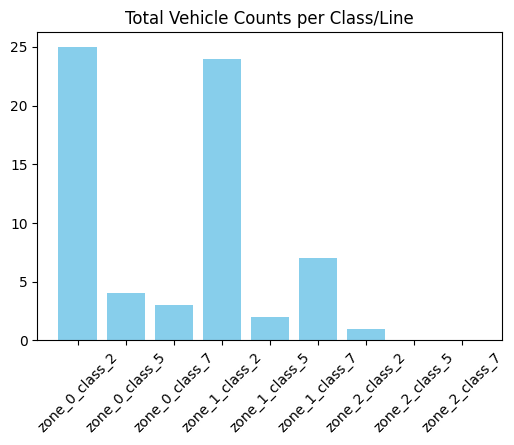

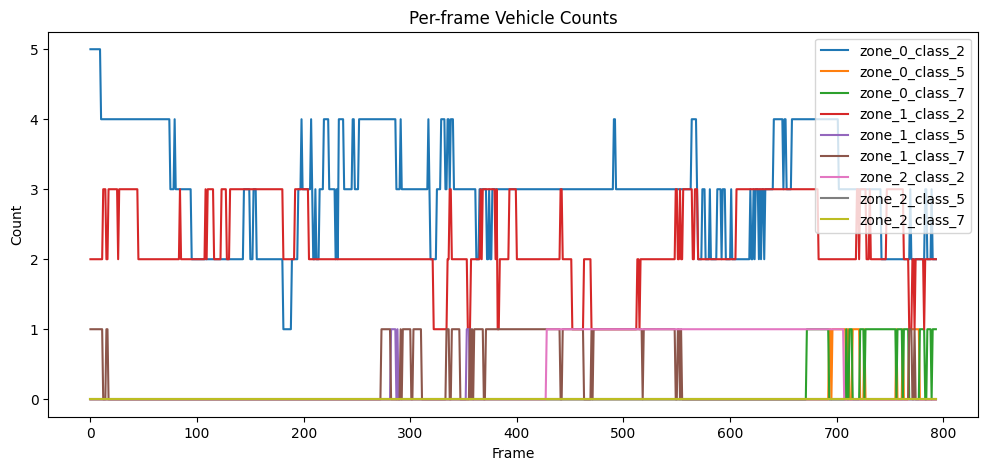

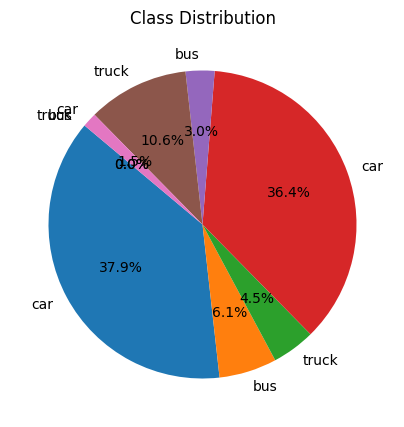

NameError: name 'trajectories' is not defined

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Final counts bar chart
plt.figure(figsize=(6,4))
plt.bar(final_counts.keys(), final_counts.values(), color="skyblue")
plt.xticks(rotation=45)
plt.title("Total Vehicle Counts per Class/Line")
plt.show()

# 2. Time-series counts
per_frame_df.plot(figsize=(12,5))
plt.title("Per-frame Vehicle Counts")
plt.xlabel("Frame")
plt.ylabel("Count")
plt.show()

# 3. Distribution pie chart
labels = [CLASS_NAMES[int(k.split("_")[-1])] for k in final_counts.keys()]
sizes = list(final_counts.values())
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution")
plt.show()

# 4. Heatmap of vehicle positions
all_points = np.array([center for track in trajectories.values() for center in track])
if len(all_points) > 0:
    plt.figure(figsize=(8,6))
    sns.kdeplot(x=all_points[:,0], y=all_points[:,1], fill=True, cmap="Reds", thresh=0.05)
    plt.gca().invert_yaxis()
    plt.title("Traffic Density Heatmap")
    plt.show()
